# Traffic Sign Detection

Dataset: https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Using a RCNN approach:
1. selective search to spot potential candidates for traffic signs
2. classify the candidates
3. non-maximum suppression

Training a multiclass classifier to determine which kind of traffic sign each candidate is (or if background)

In [1]:
import cv2
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import helper
import os
import copy
from tqdm.notebook import tqdm
import seaborn as sn
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score
import sklearn
from collections import Counter
import random
from PIL import Image
import collections

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(15)
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9', 'background']


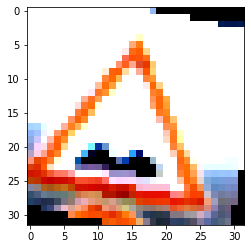

In [16]:
train_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(38),
    torchvision.transforms.RandomRotation(15),
    torchvision.transforms.RandomResizedCrop(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.CenterCrop(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_validate_dataset = torchvision.datasets.ImageFolder('./traffic-signs/Train', transform=train_preprocess)
train_dataset_length = int(len(train_validate_dataset) * 0.9)
val_dataset_length = len(train_validate_dataset) - train_dataset_length
train_dataset, val_dataset= torch.utils.data.random_split(train_validate_dataset, [train_dataset_length, val_dataset_length])
test_dataset = torchvision.datasets.ImageFolder('./traffic-signs/Test', transform=test_preprocess)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = val_dataloader
dataset_sizes = {}
dataset_sizes['train'] = train_dataset_length
dataset_sizes['val'] = val_dataset_length

images, labels = next(iter(train_dataloader))
plt.imshow(np.moveaxis(images[0].numpy(), 0, -1))
print(labels[0])

class_names = train_validate_dataset.classes
print(sorted(class_names))

device = torch.device('cuda:0')


<AxesSubplot:>

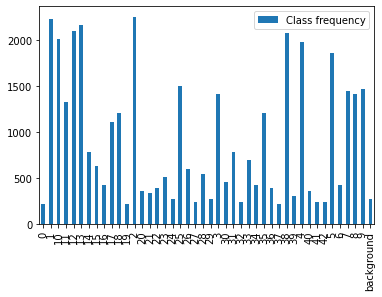

In [19]:
classes = [ class_names[image[1]] for image in train_validate_dataset ]
class_counter = Counter(classes)

pd.DataFrame.from_dict(class_counter, orient='index', columns=['Class frequency']).plot(kind='bar')

In [21]:
class CNN(nn.Module):
    def __init__(self, classes):
        super(CNN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, classes))
        
    def forward(self, x):
        return self.layers(x)
        
model = CNN(len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.01 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.01)

model

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, return_best=True):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc.append(epoch_acc.cpu().numpy())
                train_loss.append(epoch_loss)
            else:
                val_acc.append(epoch_acc.cpu().numpy())
                val_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    if return_best:
        model.load_state_dict(best_model_wts)
    return model, { 'train': { 'acc': train_acc, 'loss': train_loss }, 'val': { 'acc': val_acc, 'loss': val_loss } }

In [23]:
def evaluate_model(model):
    model.eval()
    
    correct = 0
    total = 0
    
    y_labels = []
    y_pred = []

    with torch.no_grad():
        for (inputs, labels) in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            y_labels.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_labels), np.array(y_pred), correct / total

In [24]:
model, history = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
history

Epoch 0/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 2.4439 Acc: 0.2812


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 1.8705 Acc: 0.4177

Epoch 1/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 1.3614 Acc: 0.5684


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.9151 Acc: 0.7181

Epoch 2/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.8476 Acc: 0.7387


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.7105 Acc: 0.7870

Epoch 3/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5974 Acc: 0.8191


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.5167 Acc: 0.8419

Epoch 4/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5402 Acc: 0.8344


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4834 Acc: 0.8569

Epoch 5/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5163 Acc: 0.8414


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4455 Acc: 0.8635

Epoch 6/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5058 Acc: 0.8450


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4725 Acc: 0.8541

Epoch 7/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5092 Acc: 0.8418


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4753 Acc: 0.8528

Epoch 8/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5169 Acc: 0.8418


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4535 Acc: 0.8612

Epoch 9/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5181 Acc: 0.8417


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4609 Acc: 0.8544

Epoch 10/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5189 Acc: 0.8403


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4407 Acc: 0.8683

Epoch 11/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5196 Acc: 0.8405


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4261 Acc: 0.8685

Epoch 12/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5060 Acc: 0.8431


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4913 Acc: 0.8501

Epoch 13/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5071 Acc: 0.8432


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4765 Acc: 0.8559

Epoch 14/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5077 Acc: 0.8436


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4510 Acc: 0.8604

Epoch 15/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5069 Acc: 0.8423


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4743 Acc: 0.8528

Epoch 16/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5068 Acc: 0.8432


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4724 Acc: 0.8564

Epoch 17/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5072 Acc: 0.8438


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4721 Acc: 0.8561

Epoch 18/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5080 Acc: 0.8458


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4573 Acc: 0.8589

Epoch 19/19
----------


  0%|          | 0/1111 [00:00<?, ?it/s]

train Loss: 0.5054 Acc: 0.8470


  0%|          | 0/124 [00:00<?, ?it/s]

val Loss: 0.4885 Acc: 0.8495

Training complete in 129m 7s
Best val Acc: 0.868541


{'train': {'acc': [array(0.28124736),
   array(0.56840505),
   array(0.73870704),
   array(0.81905941),
   array(0.83442628),
   array(0.8414061),
   array(0.84498044),
   array(0.84177197),
   array(0.84182826),
   array(0.8416594),
   array(0.84033661),
   array(0.84047733),
   array(0.84309476),
   array(0.8431792),
   array(0.84360136),
   array(0.84227857),
   array(0.84320734),
   array(0.84382652),
   array(0.84582477),
   array(0.84695055)],
  'loss': [2.443937581187582,
   1.3613803659959365,
   0.8476421480386043,
   0.597386707278155,
   0.540235476160542,
   0.5162631536660081,
   0.5058253733642276,
   0.5092321676122042,
   0.5169436862076108,
   0.5181240300430856,
   0.5189002489727256,
   0.5195658870372895,
   0.506045352716114,
   0.507068345181086,
   0.5076574866091489,
   0.5068880687278375,
   0.506768829480792,
   0.5071867860394236,
   0.5079721866451226,
   0.5054324559056083]},
 'val': {'acc': [array(0.41767984),
   array(0.71808511),
   array(0.78698075),
  

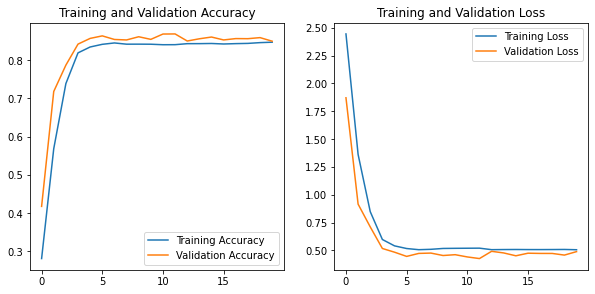

In [25]:
acc = history['train']['acc']
val_acc = history['val']['acc']

loss = history['train']['loss']
val_loss = history['val']['loss']

epochs_range = range(20)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

  0%|          | 0/399 [00:00<?, ?it/s]

Test Accuracy: 0.97266


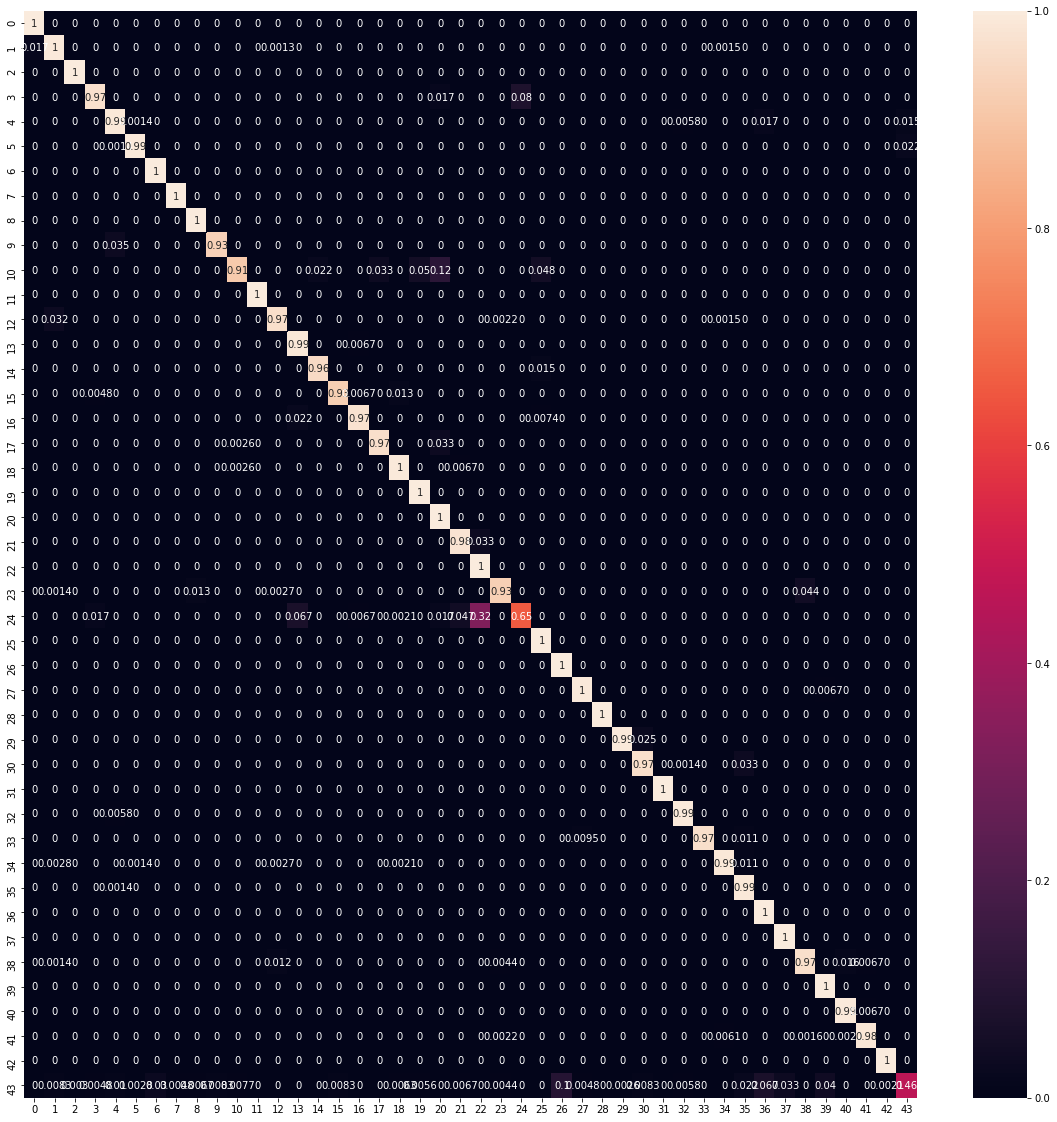

F1 score: 0.97151
Precision score: 0.97326
Recall score: 0.97266
Class distribution: dict_items([(10, 390), (25, 270), (38, 630), (35, 90), (32, 690), (13, 90), (34, 660), (12, 750), (5, 720), (1, 720), (9, 360), (8, 150), (41, 450), (21, 150), (27, 210), (2, 660), (36, 60), (23, 450), (14, 90), (33, 90), (18, 480), (40, 450), (29, 390), (4, 690), (42, 480), (37, 90), (20, 60), (19, 180), (39, 150), (3, 420), (6, 270), (0, 60), (30, 120), (43, 134), (22, 90), (16, 150), (15, 120), (7, 210), (24, 150), (28, 120), (26, 60), (11, 60), (17, 90), (31, 60)])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


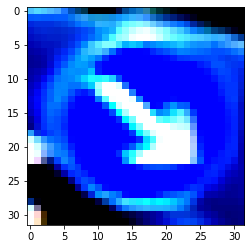

True Label: 32 38
Predicted Label: 32 38


In [26]:
y_label, y_pred, acc = evaluate_model(model)

print('Test Accuracy: %.5f' % (acc))

confusion_matrix = sklearn.metrics.confusion_matrix(y_label, y_pred)

normalized_confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)

data_cm = pd.DataFrame(normalized_confusion_matrix)
plt.figure(figsize = (20,20))
sn.heatmap(data_cm, annot=True)
plt.show()

print('F1 score: %.5f' % f1_score(y_label, y_pred, average='weighted'))
print('Precision score: %.5f' % precision_score(y_label, y_pred, average='weighted'))
print('Recall score: %.5f' % recall_score(y_label, y_pred, average='weighted'))
print('Class distribution:', Counter(y_label).items())

test_data = next(iter(test_dataloader))
image = test_data[0][0:1]
label = test_data[1][0].numpy()

prediction = torch.max(model(image.to(device)), 1).indices.cpu().numpy()[0]

plt.imshow(np.moveaxis(image[0].numpy(), 0, -1))
plt.show()
print('True Label:', label, class_names[label])
print('Predicted Label:', prediction, class_names[prediction])

In [27]:
import torch.onnx

# Input to the model
model_in = torch.randn(32, 3, 32, 32, requires_grad=True).to(device)
model_out = model(model_in)

# Export the model
torch.onnx.export(model,
                  model_in,
                  'sign-detection.onnx',
                  export_params=True,
                  input_names = ['input'],
                  output_names = ['output'])

In [28]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes    
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

Selective search: 84.07885313034058 seconds
Preprocess: 1.3107397556304932 seconds
Prediction: 1.8978097438812256 seconds
Detected: 14
Detected: 35
Postprocess: 0.022727489471435547 seconds
Total 87.31013011932373 seconds


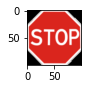

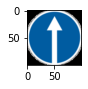

In [59]:
BATCH_SIZE = 32
RECTANGLES = 1024
OVERLAP_THRESHOLD = 0.75
PROBABILITY_THRESHOLD = 0.9

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.CenterCrop(32),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image = cv2.imread('./traffic-signs/test_traffic2.jpg')
#image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2), cv2.INTER_CUBIC)

def detect(image, model, class_names, device):
    start = time.time()
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()

    rects = ss.process()[:RECTANGLES]
    
    search_end = time.time()
    print('Selective search:', search_end - start, 'seconds')
    extracted = [ image[y:y+h, x:x+w] for (x, y, w, h) in rects ]
    extracted = [ preprocess(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).numpy() for image in extracted ]

    preprocess_end = time.time()
    print ('Preprocess:', preprocess_end - search_end, 'seconds')
    
    class_probabilities = []

    for i in range(0, len(extracted), BATCH_SIZE):
        batch_tensor = torch.as_tensor(np.array(extracted[i:i+BATCH_SIZE])).to(device)
        probabilities_tensor = nn.functional.softmax(model(batch_tensor), 1).cpu().detach().numpy()
        batch_class_probabilities = [ (class_names[np.argmax(probability)], np.max(probability)) for probability in probabilities_tensor ]
        class_probabilities.extend(batch_class_probabilities)
        
    prediction_end = time.time()
    print ('Prediction:', prediction_end - preprocess_end, 'seconds')
        
    class_probabilities_and_rects = list(zip(class_probabilities, rects))
    filtered_class_probabilities = [ ((clazz, probability), (x, y, w, h)) for ((clazz, probability), (x, y, w, h)) in class_probabilities_and_rects if probability > PROBABILITY_THRESHOLD and clazz != 'background' and w <= 1.3 * h and h <= 1.3 * w ]

    boxes_per_class = collections.defaultdict(list)

    for ((clazz, probability), (x, y, w, h)) in filtered_class_probabilities:
        boxes_per_class[clazz].append((x, y, x+w, y+h))
        
    filtered_boxes_per_class = {}
    for (clazz, boxes) in boxes_per_class.items():
        filtered_boxes_per_class[clazz] = non_max_suppression_fast(np.array(boxes), OVERLAP_THRESHOLD)
        print('Detected:', clazz)

    filtered_boxes_per_class = [ (clazz, box) for (clazz, boxes) in filtered_boxes_per_class.items() for box in boxes ]

    end = time.time()
    print ('Postprocess:', end - prediction_end, 'seconds')
    print('Total', end - start, 'seconds')
    return list(boxes_per_class.keys()), filtered_boxes_per_class

classes, boxes = detect(image, model, class_names, device)

for clazz in classes:
    sign_image = cv2.imread('./traffic-signs/Meta/%s.png' % clazz)
    plt.figure(figsize = (1,1))
    plt.imshow(cv2.cvtColor(sign_image, cv2.COLOR_BGR2RGB))
    plt.plot()

[]

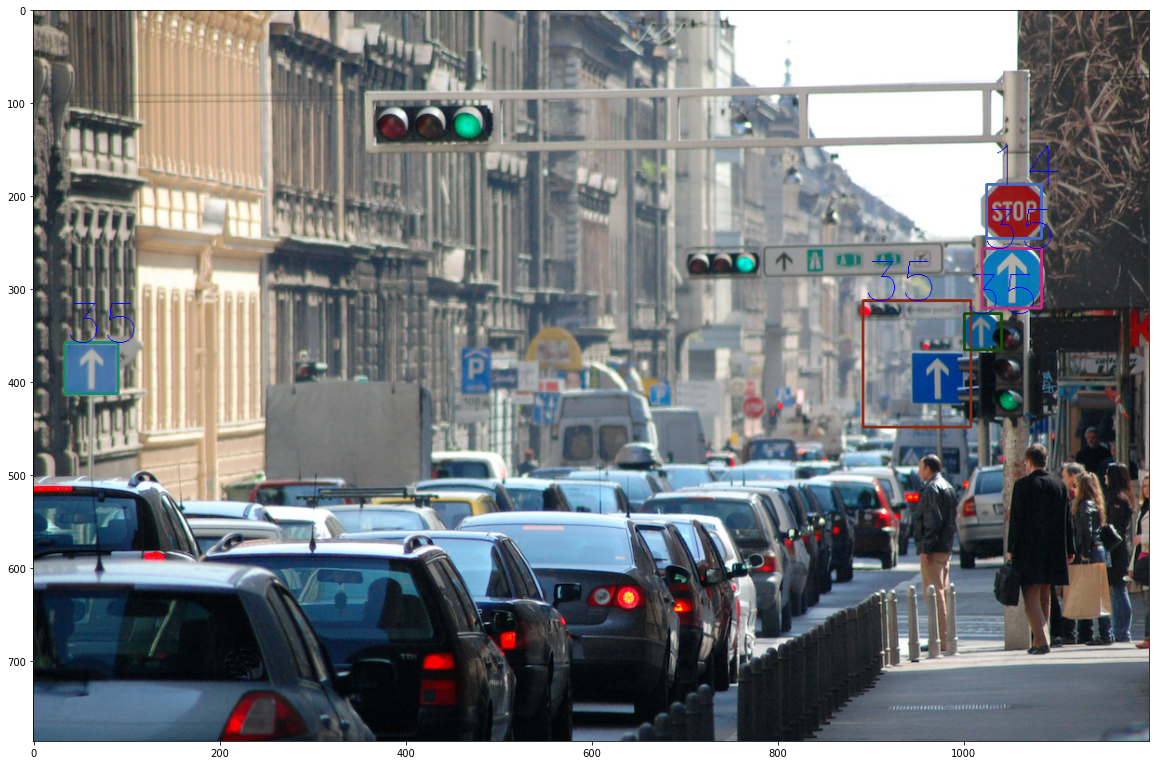

In [60]:
output = image.copy()
for (clazz, (x1, y1, x2, y2)) in boxes:
    # draw the region proposal bounding box on the image
    color = [random.randint(0, 255) for j in range(0, 3)]
    cv2.rectangle(output, (x1, y1), (x2, y2), color, 2)
    cv2.putText(output, clazz, (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    
plt.figure(figsize = (20,20))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.plot()

In [55]:
import uuid

for (_, (x1, y1, x2, y2)) in boxes:
        name = uuid.uuid4()
        cv2.imwrite('./traffic-signs/background/' + str(name) + '.png', image[y1:y2, x1:x2])
        print('Wrote', './traffic-signs/background/' + str(name) + '.png')

Wrote ./traffic-signs/background/786a9f8c-72b1-412f-b775-c2c932447364.png
Wrote ./traffic-signs/background/3f565289-6b19-4692-9d97-95fc89106162.png


In [ ]:
sign = image[120:180, 670:730]

plt.imshow(sign)
plt.show()

extracted = [ preprocess(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))).numpy() for image in [sign] ]

In [ ]:
plt.imshow(np.moveaxis(extracted[3], 0, -1))
plt.show()

In [8]:
images = ['./traffic-signs/traffic1.jpg', './traffic-signs/traffic2.jpg', './traffic-signs/traffic3.jpg', './traffic-signs/traffic4.jpg', './traffic-signs/traffic5.jpg', './traffic-signs/traffic6.jpg', './traffic-signs/traffic7.jpg', './traffic-signs/traffic8.jpg', './traffic-signs/traffic9.jpg'] 

for i, name in enumerate(images):
    print('Image', name)

    image = cv2.imread(name)

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    #ss.switchToSelectiveSearchQuality()
    ss.switchToSelectiveSearchFast()

    start = time.time()
    rects = ss.process()
    end = time.time()

    rects = rects[:45]
    print('Processed 45 rectangles in %i sec' % (end - start))

    #print(end - start)
    #print(len(rects))
    #print(image.shape)

    #os.mkdir('./traffic-signs/background')

    #output = image.copy()
    for index, (x, y, w, h) in enumerate(rects):
        # draw the region proposal bounding box on the image
        #color = [random.randint(0, 255) for j in range(0, 3)]
        #cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
        cv2.imwrite('./traffic-signs/background/' + str(i) + '_' + str(index) + '.png', image[y:y+h, x:x+w])
        print('Wrote', './traffic-signs/background/' + str(i) + '_' + str(index) + '.png')

    #plt.imshow(output)
    #plt.plot()

Image ./traffic-signs/traffic9.jpg
Processed 45 rectangles in 6 sec
Wrote ./traffic-signs/background/8_0.png
Wrote ./traffic-signs/background/8_1.png
Wrote ./traffic-signs/background/8_2.png
Wrote ./traffic-signs/background/8_3.png
Wrote ./traffic-signs/background/8_4.png
Wrote ./traffic-signs/background/8_5.png
Wrote ./traffic-signs/background/8_6.png
Wrote ./traffic-signs/background/8_7.png
Wrote ./traffic-signs/background/8_8.png
Wrote ./traffic-signs/background/8_9.png
Wrote ./traffic-signs/background/8_10.png
Wrote ./traffic-signs/background/8_11.png
Wrote ./traffic-signs/background/8_12.png
Wrote ./traffic-signs/background/8_13.png
Wrote ./traffic-signs/background/8_14.png
Wrote ./traffic-signs/background/8_15.png
Wrote ./traffic-signs/background/8_16.png
Wrote ./traffic-signs/background/8_17.png
Wrote ./traffic-signs/background/8_18.png
Wrote ./traffic-signs/background/8_19.png
Wrote ./traffic-signs/background/8_20.png
Wrote ./traffic-signs/background/8_21.png
Wrote ./traffic-si

In [ ]:
test_data = pd.read_csv('./traffic-signs/Test.csv')

#for classId in set(test_data['ClassId'].values):
#    os.mkdir('./traffic-signs/Test/' + str(classId))

test_data['CleanedPath'] = test_data['Path'].apply(lambda x: x.split('/')[1])

for classId, filename in test_data[['ClassId', 'CleanedPath']].values:
    os.rename('./traffic-signs/Test/' + filename, './traffic-signs/Test/' + str(classId) + '/' + filename)

In [9]:
files = os.listdir('./traffic-signs/background/')
files = [ file for file in files if '.png' in file ]

random.shuffle(files)

file_count = len(files)

train_files = files[: (2 * file_count) // 3]
test_files = files[(2 * file_count) // 3:]

print(train_files)
print(test_files)

os.mkdir('./traffic-signs/Train/background')

for filename in train_files:
    os.rename('./traffic-signs/background/' + filename, './traffic-signs/Train/background/' + filename)
    
os.mkdir('./traffic-signs/Test/background')

for filename in test_files:
    os.rename('./traffic-signs/background/' + filename, './traffic-signs/Test/background/' + filename)

['7_37.png', '8_40.png', '2_13.png', '5_19.png', '6_10.png', '2_26.png', '5_4.png', '3_37.png', '6_44.png', '4_6.png', '2_16.png', '8_8.png', '8_21.png', '8_27.png', '1_9.png', '4_28.png', '2_19.png', '4_44.png', '1_29.png', '3_23.png', '8_6.png', '8_4.png', '7_16.png', '7_44.png', '1_11.png', '5_22.png', '5_33.png', '0_35.png', '6_3.png', '7_20.png', '5_7.png', '3_0.png', '6_0.png', '5_13.png', '2_27.png', '2_31.png', '6_23.png', '4_32.png', '2_22.png', '7_22.png', '2_29.png', '7_19.png', '8_26.png', '3_13.png', '7_5.png', '6_1.png', '1_36.png', '6_15.png', '2_41.png', '4_14.png', '1_37.png', '0_4.png', '5_8.png', '0_36.png', '0_13.png', '1_3.png', '1_23.png', '1_20.png', '4_36.png', '2_21.png', '6_6.png', '0_27.png', '3_8.png', '6_21.png', '0_19.png', '0_11.png', '2_12.png', '2_14.png', '5_42.png', '6_16.png', '8_0.png', '0_40.png', '8_31.png', '0_9.png', '8_25.png', '8_15.png', '1_24.png', '8_24.png', '8_11.png', '4_12.png', '5_31.png', '0_16.png', '8_17.png', '6_28.png', '5_11.png'

In [ ]:
!wget https://www.deutschlandfunk.de/media/thumbs/a/a8126892aa232e593c7dc8941fa1d6b8v1_max_755x425_b3535db83dc50e27c1bb1392364c95a2.jpg?key=8d5f6b 

In [ ]:
!python3 -m pip install opencv-contrib-python

In [56]:
!rm -r ./traffic-signs/Train/.ipynb_checkpoints
!rm -r ./traffic-signs/Test/.ipynb_checkpoints

rm: cannot remove './traffic-signs/Train/.ipynb_checkpoints': No such file or directory
rm: cannot remove './traffic-signs/Test/.ipynb_checkpoints': No such file or directory
